# Assignment
Lab04-2 110065508 李丞恩

In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os
from IPython.display import display

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
if not os.path.exists('./output_HW'):
    os.makedirs('./output_HW')

## Read dataset

In [3]:
X = pd.read_csv('./data/X_train.csv')
y = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
print(X.shape)
print(X.columns)
print(y.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [4]:
X.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


In [5]:
y.head()

,FGM
0,0
1,1
2,1
3,1
4,1


In [6]:
y = y['FGM']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

## RandomForest Classifier
利用lab3的方法選出最重要的3個feature。

In [7]:
# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=1000, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, n_jobs=2,
                       random_state=1)

In [8]:
y_pred = forest.predict(X_val)
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
print('Accuracy per feature: %.2f' % (accuracy_score(y_val, y_pred)/X.shape[1]))

Accuracy: 0.60
Accuracy per feature: 0.08


## feature selection
這部分的code使用lab3的code，藉由random forest來決定誰是最重要的feature。經過繪圖後可以發現最重要的特徵是"GAME_CLOCK", "SHOT_DIST", "SHOT_CLOCK"。

 1) GAME_CLOCK                     0.206134
 2) SHOT_DIST                      0.196265
 3) SHOT_CLOCK                     0.188145
 4) CLOSE_DEF_DIST                 0.168176
 5) TOUCH_TIME                     0.140258
 6) PERIOD                         0.048621
 7) DRIBBLES                       0.045976
 8) PTS_TYPE                       0.006424


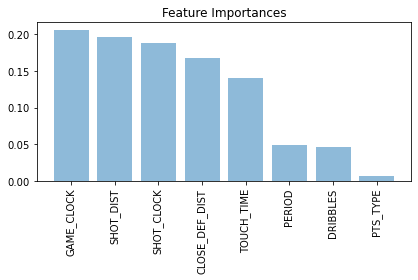

In [9]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

# list the importance of each feature
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X.columns.values[indices[f]], importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.tight_layout()
plt.savefig('./output_HW/fig-forest-feature-importances-nba.png', dpi=300)
plt.show()

## Logistic Regression
這裡我使用以前大學修機器學習導論時用過的邏輯斯回歸來做分類。

In [12]:
X = pd.read_csv('./data/X_train.csv')
y = pd.read_csv('./data/y_train.csv')
X2 = pd.read_csv('./data/X_test.csv')
print(X.shape)
print(X.columns)
print(y.columns)
X_new = X.loc[:, ["GAME_CLOCK", "SHOT_DIST", "SHOT_CLOCK"]].values
X_test2 = X2.loc[:, ["GAME_CLOCK", "SHOT_DIST", "SHOT_CLOCK"]].values
y = y['FGM']
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_new, y, test_size=0.2, stratify=y, random_state=0)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train2)
X_val_std = sc.fit_transform(X_val2)
X_test_std = sc.transform(X_test2)

In [23]:
# 呼叫邏輯斯回歸
lr = LogisticRegression(random_state=0, C = 1)
lr = lr.fit(X_train_std, y_train2)
y_pred2 = lr.predict(X_val_std)
print('Accuracy: %.2f' % accuracy_score(y_val2, y_pred))

Accuracy: 0.60


預測出y_pred後存到csv檔案裡面。

In [25]:
y_pred_test = lr.predict(X_test_std)
df = pd.DataFrame({'FGM': y_pred_test})
df.to_csv("./output_HW/y_pred.csv", index=False)